In [118]:
import copy

import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

class KNNClassifier:
    metric_type = 'minkowski'
    p = None
    kernel = None
    X_train = None
    y_train = None
    annoy_i = None
    n_trees = 10
    memcached = dict()
    lowess_weights = list()
    
    def __init__(self, kernel=lambda x: 1 - np.abs(x), metric='minkowski', p=2.0):
        self.kernel = kernel
        self.metric_type = metric
        self.p = p
        
    def get_distances(self):
        dists = list()
        
        for i in range(len(self.X_vals)):
            for j in range(i + 1, len(self.X_vals)):
                dists.append(self.metric(self.X_vals[i], self.X_vals[j]))
                
        return np.asarray(dists)
        
    def metric(self, a, b):
        if self.metric_type == 'minkowski':
            return np.sum(np.abs(a - b) ** self.p) ** (1.0 / self.p)
        if self.metric_type == 'cosine':
            return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        if self.metric_type == 'chebyshev':
            return np.max(np.abs(a - b))
        
        raise AttributeError(f'no metric with name {self.metric_type}')
    
    def fit(self, X, y):
        self.X_vals = X.values
        self.y_vals = y.values
        self.X_train = X
        self.y_train = y
        self.counter_pattern = dict()
        self.memcached = dict()
        self.lowess_weights = list()
        
        for label in np.unique(self.y_train):
            self.counter_pattern[label] = 0
    
    def base_predict(self, X, neighboubrs_mapper, element_processor, double_compute=False):
        nn = NearestNeighbors(
            metric=self.metric_type,
            p=self.p
        )
    
        nn.fit(self.X_train)
        dists, neighs = neighboubrs_mapper(nn)(X)
        if double_compute:
            dists_X, neighs_X = neighboubrs_mapper(nn)(self.X_train)
            for i in range(len(X_train)):
                self.memcached[i] = self.__float_window_processor(dists_X[i][1:], neighs_X[i][1:])
        
        y_test = list()
        
        for i in range(len(X)):
            pred = element_processor(dists[i], neighs[i])
            y_test.append(pred)
            
        return np.asarray(y_test)
    
    def __constant_window_processor(self, dists, neighs):
        tmp_counter = copy.deepcopy(self.counter_pattern)
            
        # no neigh
        if len(dists) == 0:
            return None, None
            
        for (dist, neigh) in zip(dists, neighs):
            n_type = self.y_vals[neigh]
            
            tmp_counter[n_type] += self.kernel(dist / h)

        pred = max(tmp_counter, key=tmp_counter.get)
        
        return pred
    
    def __float_window_processor(self, dists, neighs):
        tmp_counter = copy.deepcopy(self.counter_pattern)
        
        for (dist, neigh) in zip(dists[:-1], neighs[:-1]):
            n_type = self.y_vals[neigh]
            
            tmp_counter[n_type] += self.kernel(dist / dists[-1])
            
        pred = max(tmp_counter, key=tmp_counter.get)
        
        return pred
    
    def __lowess_window_processor(self, dists, neighs):
        tmp_counter = copy.deepcopy(self.counter_pattern)
        
        for (dist, neigh) in zip(dists[:-1], neighs[:-1]):
            n_type = self.y_vals[neigh]
            
            tmp_counter[n_type] += self.kernel(n_type - self.memcached[neigh])
            
        pred = max(tmp_counter, key=tmp_counter.get)
        
        return pred  
    
    def predict_constant_window(self, X, h):
        return self.base_predict(X, lambda nn: lambda x: nn.radius_neighbors(X=x, radius=h), self.__constant_window_processor)
    
    def predict_float_window(self, X, k):
        return self.base_predict(X, lambda nn: lambda x: nn.kneighbors(X=x, n_neighbors=k + 1), self.__float_window_processor)
    
    def predict_float_lowess_window(self, X, k):
        return self.base_predict(X, lambda nn: lambda x: nn.kneighbors(X=x, n_neighbors=k + 1), self.__lowess_window_processor, double_compute=True)


### Ядра

In [119]:
def base_kernel_constructor(a, b, c):
    return lambda x: c * (1 - np.abs(a) ** a) ** b

default_kernel = base_kernel_constructor(1, 1, 1)

def gaussian_kernel(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * x**2)

epanechnikov_kernel = base_kernel_constructor(0.75, 2, 1)

def cosine_kernel(x):
    return np.pi / 4 * np.cos(np.pi / 2 * x)

def uniform_kernel(ignored):
    return 0.5

triquadratic_kernel = base_kernel_constructor(35.0/32, 2, 3)


### Подготовим данные

In [120]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('phone_infos.csv')
X = df.drop(columns=['price_range'])
y = df['price_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=153)

X_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
1955,1515,1,2.1,1,4,1,24,0.9,176,5,6,747,1247,3104,6,5,20,1,0,0
1549,1772,1,1.6,0,17,1,45,0.5,159,2,18,837,1405,1146,6,1,17,1,1,0
188,1905,1,0.5,0,3,1,6,0.5,151,1,5,849,898,1545,9,5,10,1,1,0
1242,989,1,1.6,1,11,1,24,0.6,156,8,17,614,679,2819,16,13,5,1,0,1
1199,894,0,0.7,0,2,1,58,0.1,123,2,3,158,747,3305,12,7,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,902,1,0.7,0,3,0,3,0.3,134,7,9,675,1285,3411,12,11,15,0,0,1
1484,1689,1,0.5,0,11,0,9,0.5,150,5,15,467,675,2637,8,4,3,1,0,0
1530,571,1,2.0,1,5,1,58,0.6,101,6,11,31,1536,555,19,10,11,1,0,1
385,1880,1,1.8,0,4,1,18,0.7,138,3,5,71,699,3333,17,15,7,1,0,0


### Попробуем запустить с константным окном

In [122]:
h = 1450

knn = KNNClassifier(metric='minkowski', p=10)
knn.fit(X_train, y_train)
y_test1 = knn.predict_constant_window(X_test, h)

knn_sklearn = RadiusNeighborsClassifier(radius=h)
knn_sklearn.fit(X_train, y_train)
y_test2 = knn_sklearn.predict(X_test)

print("ours", accuracy_score(y_test.values, y_test1))
print("theirs", accuracy_score(y_test, y_test2))
print("ours vs theirs", accuracy_score(y_test1, y_test2))

ours 0.86375
theirs 0.75625
ours vs theirs 0.885


### Попробуем немного ограничить круг перебора гиперпараметров, посмотрим стату по расстояниям:

In [123]:
d = knn.get_distances()

In [125]:
d.min(), d.mean(), d.max()

(34.22824108007353, 1450.7278599704268, 3735.0019262323017)

### Попробуем с переменным окном

In [ ]:
k = 5

knn = KNNClassifier(kernel=epanechnikov_kernel)
knn.fit(X_train, y_train)
y_test1, = knn.predict_float_window(X_test, k)

knn_sklearn = KNeighborsClassifier(n_neighbors=k)
knn_sklearn.fit(X_train, y_train)
y_test2 = knn_sklearn.predict(X_test)

print("ours", accuracy_score(y_test.values, y_test1))
print("theirs", accuracy_score(y_test, y_test2))
print("ours vs theirs", accuracy_score(y_test1, y_test2))

 ### Оптимизируем гиперпараметры

In [126]:
import optuna

def objective_const(trial: optuna.trial.Trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    p = None
    
    if metric == 'minkowski':
        p = trial.suggest_float('p', 1, 10)
        
    h = trial.suggest_float('h', 1200, 4000)
    kernel = trial.suggest_categorical('kernel', ['default', 'epanechnikov', 'gaussian', 'cosine', 'uniform', 'triquadratic'])
    
    knn = KNNClassifier(
        metric=metric,
        p=p,
        kernel=globals()[f'{kernel}_kernel']
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict_constant_window(X_test, h)
    
    return 1 - accuracy_score(y_test, y_pred)

study_const = optuna.create_study()  
study_const.optimize(objective_const, n_jobs=-1, n_trials=1000, show_progress_bar=True)
study_const.best_params

[I 2024-04-04 14:48:25,445] A new study created in memory with name: no-name-a6fa7fe0-d1e1-4bbb-befa-5de5eaa213cd


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-04-04 14:48:27,352] Trial 3 finished with value: 0.76375 and parameters: {'metric': 'cosine', 'h': 2661.984260078141, 'kernel': 'uniform'}. Best is trial 3 with value: 0.76375.
[I 2024-04-04 14:48:27,364] Trial 1 finished with value: 0.76375 and parameters: {'metric': 'cosine', 'h': 1608.3040473784226, 'kernel': 'uniform'}. Best is trial 3 with value: 0.76375.
[I 2024-04-04 14:48:29,122] Trial 4 finished with value: 0.35624999999999996 and parameters: {'metric': 'minkowski', 'p': 3.1153934612815286, 'h': 1708.3522394504516, 'kernel': 'epanechnikov'}. Best is trial 4 with value: 0.35624999999999996.
[I 2024-04-04 14:48:29,737] Trial 5 finished with value: 0.385 and parameters: {'metric': 'minkowski', 'p': 5.992251439720092, 'h': 1730.5316181445905, 'kernel': 'triquadratic'}. Best is trial 4 with value: 0.35624999999999996.
[I 2024-04-04 14:48:29,778] Trial 0 finished with value: 0.49375 and parameters: {'metric': 'chebyshev', 'h': 2140.5360989021065, 'kernel': 'triquadratic'}. B

{'metric': 'minkowski',
 'p': 1.01074728135753,
 'h': 1714.8770121292023,
 'kernel': 'cosine'}

In [127]:
import optuna

def objective_float(trial: optuna.trial.Trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    p = None
    
    if metric == 'minkowski':
        p = trial.suggest_float('p', 1, 10)
        
    k = trial.suggest_int('k', 1, len(X_train.values) - 1)
    kernel = trial.suggest_categorical('kernel', ['default', 'epanechnikov', 'gaussian', 'cosine', 'uniform', 'triquadratic'])
    
    knn = KNNClassifier(
        metric=metric,
        p=p,
        kernel=globals()[f'{kernel}_kernel']
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict_float_window(X_test, k)
    
    return 1 - accuracy_score(y_test, y_pred)

study = optuna.create_study()  
study.optimize(objective_float, n_jobs=-1, n_trials=1000, show_progress_bar=True)  
study.best_params


[I 2024-04-04 14:57:13,207] A new study created in memory with name: no-name-163db351-9b6c-4c67-aa8b-39803faa03ec


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-04-04 14:57:14,552] Trial 0 finished with value: 0.09375 and parameters: {'metric': 'chebyshev', 'k': 118, 'kernel': 'triquadratic'}. Best is trial 0 with value: 0.09375.
[I 2024-04-04 14:57:14,622] Trial 6 finished with value: 0.08875 and parameters: {'metric': 'minkowski', 'p': 4.815767691675515, 'k': 109, 'kernel': 'triquadratic'}. Best is trial 6 with value: 0.08875.
[I 2024-04-04 14:57:15,185] Trial 1 finished with value: 0.7475 and parameters: {'metric': 'minkowski', 'p': 4.508753126190431, 'k': 312, 'kernel': 'default'}. Best is trial 6 with value: 0.08875.
[I 2024-04-04 14:57:15,397] Trial 3 finished with value: 0.11375000000000002 and parameters: {'metric': 'chebyshev', 'k': 264, 'kernel': 'gaussian'}. Best is trial 6 with value: 0.08875.
[I 2024-04-04 14:57:15,698] Trial 8 finished with value: 0.7475 and parameters: {'metric': 'cosine', 'k': 25, 'kernel': 'default'}. Best is trial 6 with value: 0.08875.
[I 2024-04-04 14:57:15,711] Trial 2 finished with value: 0.16625 

{'metric': 'chebyshev', 'k': 24, 'kernel': 'cosine'}

In [128]:
import optuna

def objective_float_sklearn(trial: optuna.trial.Trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    p = None
    
    if metric == 'minkowski':
        p = trial.suggest_float('p', 1, 10, log=True)
        
    k = trial.suggest_int('k', 1, len(X_train.values) - 1, log=True)
    
    kernel = trial.suggest_categorical('kernel', ['uniform', 'distance'])

    knn = KNeighborsClassifier(
        metric=metric,
        p=p,
        weights=kernel,
        n_neighbors=k
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
        
    return 1 - accuracy_score(y_test.values, y_pred)

study = optuna.create_study()  
study.optimize(objective_float_sklearn, n_jobs=1, n_trials=1000, show_progress_bar=True)  
study.best_params


[I 2024-04-04 15:00:52,718] A new study created in memory with name: no-name-73e9b588-d67c-444e-8f47-1630e4e7de8e


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-04-04 15:00:52,763] Trial 0 finished with value: 0.41000000000000003 and parameters: {'metric': 'cosine', 'k': 43, 'kernel': 'distance'}. Best is trial 0 with value: 0.41000000000000003.
[I 2024-04-04 15:00:52,827] Trial 1 finished with value: 0.10624999999999996 and parameters: {'metric': 'minkowski', 'p': 1.4777745569319545, 'k': 1, 'kernel': 'uniform'}. Best is trial 1 with value: 0.10624999999999996.
[I 2024-04-04 15:00:52,871] Trial 2 finished with value: 0.21375 and parameters: {'metric': 'chebyshev', 'k': 645, 'kernel': 'uniform'}. Best is trial 1 with value: 0.10624999999999996.
[I 2024-04-04 15:00:52,917] Trial 3 finished with value: 0.405 and parameters: {'metric': 'cosine', 'k': 315, 'kernel': 'distance'}. Best is trial 1 with value: 0.10624999999999996.
[I 2024-04-04 15:00:52,927] Trial 4 finished with value: 0.07999999999999996 and parameters: {'metric': 'chebyshev', 'k': 5, 'kernel': 'distance'}. Best is trial 4 with value: 0.07999999999999996.
[I 2024-04-04 15:00

{'metric': 'minkowski', 'p': 8.892780942544823, 'k': 17, 'kernel': 'distance'}

In [129]:
import optuna

def objective_const_sklearn(trial: optuna.trial.Trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    p = None
    
    if metric == 'minkowski':
        p = trial.suggest_float('p', 1, 10)
        
    h = trial.suggest_float('h', 500, 5000)
    kernel = trial.suggest_categorical('kernel', ['uniform', 'distance'])
                
    knn = RadiusNeighborsClassifier(
        metric=metric,
        p=p,
        weights=kernel,
        radius=h,
        outlier_label=5
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    return 1 - accuracy_score(y_test, y_pred)

study = optuna.create_study()  
study.optimize(objective_const_sklearn, n_jobs=1, n_trials=1000, show_progress_bar=True)
study.best_params

[I 2024-04-04 15:03:57,491] A new study created in memory with name: no-name-679c885f-0dce-4e94-b9d2-7c25730f32a8


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-04-04 15:03:57,543] Trial 0 finished with value: 0.09624999999999995 and parameters: {'metric': 'chebyshev', 'h': 4204.72349862733, 'kernel': 'distance'}. Best is trial 0 with value: 0.09624999999999995.
[I 2024-04-04 15:03:57,572] Trial 1 finished with value: 0.76375 and parameters: {'metric': 'cosine', 'h': 1314.290907727448, 'kernel': 'uniform'}. Best is trial 0 with value: 0.09624999999999995.
[I 2024-04-04 15:03:57,598] Trial 2 finished with value: 0.09624999999999995 and parameters: {'metric': 'chebyshev', 'h': 2308.065560565129, 'kernel': 'distance'}. Best is trial 0 with value: 0.09624999999999995.
[I 2024-04-04 15:03:57,617] Trial 3 finished with value: 0.56125 and parameters: {'metric': 'chebyshev', 'h': 2397.2026573083067, 'kernel': 'uniform'}. Best is trial 0 with value: 0.09624999999999995.
[I 2024-04-04 15:03:57,670] Trial 4 finished with value: 0.4125 and parameters: {'metric': 'minkowski', 'p': 9.488336220372636, 'h': 1857.2723494741356, 'kernel': 'uniform'}. Be

/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


[I 2024-04-04 15:03:58,024] Trial 17 finished with value: 0.09624999999999995 and parameters: {'metric': 'chebyshev', 'h': 4200.1445620540635, 'kernel': 'distance'}. Best is trial 0 with value: 0.09624999999999995.
[I 2024-04-04 15:03:58,045] Trial 18 finished with value: 0.09125000000000005 and parameters: {'metric': 'chebyshev', 'h': 828.9611221178116, 'kernel': 'distance'}. Best is trial 18 with value: 0.09125000000000005.
[I 2024-04-04 15:03:58,098] Trial 19 finished with value: 0.07250000000000001 and parameters: {'metric': 'minkowski', 'p': 1.272495046118551, 'h': 612.8983800391102, 'kernel': 'distance'}. Best is trial 19 with value: 0.07250000000000001.
[I 2024-04-04 15:03:58,156] Trial 20 finished with value: 0.08875 and parameters: {'metric': 'minkowski', 'p': 1.273975559202343, 'h': 508.08017554858, 'kernel': 'distance'}. Best is trial 19 with value: 0.07250000000000001.
[I 2024-04-04 15:03:58,208] Trial 21 finished with value: 0.07499999999999996 and parameters: {'metric': '

/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


[I 2024-04-04 15:03:58,266] Trial 22 finished with value: 0.12749999999999995 and parameters: {'metric': 'minkowski', 'p': 1.0184780152162558, 'h': 600.7253911764799, 'kernel': 'distance'}. Best is trial 19 with value: 0.07250000000000001.
[I 2024-04-04 15:03:58,329] Trial 23 finished with value: 0.125 and parameters: {'metric': 'minkowski', 'p': 2.7162892951613085, 'h': 1227.0033608947044, 'kernel': 'distance'}. Best is trial 19 with value: 0.07250000000000001.
[I 2024-04-04 15:03:58,383] Trial 24 finished with value: 0.07874999999999999 and parameters: {'metric': 'minkowski', 'p': 1.2962945379820687, 'h': 1037.3610314563048, 'kernel': 'distance'}. Best is trial 19 with value: 0.07250000000000001.
[I 2024-04-04 15:03:58,440] Trial 25 finished with value: 0.10875000000000001 and parameters: {'metric': 'minkowski', 'p': 4.07899631994054, 'h': 1031.7612205053279, 'kernel': 'distance'}. Best is trial 19 with value: 0.07250000000000001.
[I 2024-04-04 15:03:58,497] Trial 26 finished with va

/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


[I 2024-04-04 15:04:08,435] Trial 216 finished with value: 0.0625 and parameters: {'metric': 'minkowski', 'p': 2.5790527556764644, 'h': 596.8319321059046, 'kernel': 'distance'}. Best is trial 143 with value: 0.06125000000000003.
[I 2024-04-04 15:04:08,493] Trial 217 finished with value: 0.07250000000000001 and parameters: {'metric': 'minkowski', 'p': 2.6490122005325247, 'h': 649.7278362119522, 'kernel': 'distance'}. Best is trial 143 with value: 0.06125000000000003.
[I 2024-04-04 15:04:08,551] Trial 218 finished with value: 0.08125000000000004 and parameters: {'metric': 'minkowski', 'p': 2.41629624253609, 'h': 760.768709920074, 'kernel': 'distance'}. Best is trial 143 with value: 0.06125000000000003.
[I 2024-04-04 15:04:08,607] Trial 219 finished with value: 0.09250000000000003 and parameters: {'metric': 'minkowski', 'p': 1.1112820402954597, 'h': 583.325336215216, 'kernel': 'distance'}. Best is trial 143 with value: 0.06125000000000003.
[I 2024-04-04 15:04:08,691] Trial 220 finished wi

/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


[I 2024-04-04 15:04:16,179] Trial 359 finished with value: 0.12875000000000003 and parameters: {'metric': 'minkowski', 'p': 2.5968859719308646, 'h': 1377.182483755746, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:16,234] Trial 360 finished with value: 0.07125000000000004 and parameters: {'metric': 'minkowski', 'p': 3.720187387480615, 'h': 573.8899211374517, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:16,288] Trial 361 finished with value: 0.07374999999999998 and parameters: {'metric': 'minkowski', 'p': 2.7933168793990517, 'h': 701.1270815780699, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:16,340] Trial 362 finished with value: 0.07874999999999999 and parameters: {'metric': 'minkowski', 'p': 1.303703822586975, 'h': 580.9818055549828, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:16,399] Trial 

/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


[I 2024-04-04 15:04:21,746] Trial 461 finished with value: 0.07374999999999998 and parameters: {'metric': 'minkowski', 'p': 1.6794012894187507, 'h': 500.9198595653203, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:21,812] Trial 462 finished with value: 0.07374999999999998 and parameters: {'metric': 'minkowski', 'p': 2.781658528655602, 'h': 655.2924340928026, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:21,864] Trial 463 finished with value: 0.06499999999999995 and parameters: {'metric': 'minkowski', 'p': 2.6082156279006, 'h': 573.6215337375345, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:21,890] Trial 464 finished with value: 0.40874999999999995 and parameters: {'metric': 'cosine', 'h': 796.4496467565402, 'kernel': 'distance'}. Best is trial 286 with value: 0.06000000000000005.
[I 2024-04-04 15:04:21,943] Trial 465 finished with value: 0.066

/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:768: UserWarning: Outlier label 5 is not in training classes. All class probabilities of outliers will be assigned with 0.
  warnings.warn(


[I 2024-04-04 15:04:33,397] Trial 672 finished with value: 0.09125000000000005 and parameters: {'metric': 'minkowski', 'p': 1.041766542542332, 'h': 643.7571094043515, 'kernel': 'distance'}. Best is trial 591 with value: 0.05874999999999997.
[I 2024-04-04 15:04:33,458] Trial 673 finished with value: 0.07250000000000001 and parameters: {'metric': 'minkowski', 'p': 7.947378715811786, 'h': 591.1565391298213, 'kernel': 'distance'}. Best is trial 591 with value: 0.05874999999999997.
[I 2024-04-04 15:04:33,527] Trial 674 finished with value: 0.10375000000000001 and parameters: {'metric': 'minkowski', 'p': 3.3451031268685067, 'h': 2712.195877482162, 'kernel': 'distance'}. Best is trial 591 with value: 0.05874999999999997.
[I 2024-04-04 15:04:33,591] Trial 675 finished with value: 0.09499999999999997 and parameters: {'metric': 'minkowski', 'p': 3.0604784207616635, 'h': 828.9751644723082, 'kernel': 'distance'}. Best is trial 591 with value: 0.05874999999999997.
[I 2024-04-04 15:04:33,650] Trial 

{'metric': 'minkowski',
 'p': 2.7386736879036437,
 'h': 591.2184255071463,
 'kernel': 'distance'}

### LOWESS
Строим веса, обучаем библиотечную модель на сокращённом трейне, смотрим на результаты

In [130]:
nn = KNNClassifier(
    metric='minkowski',
    p=8.214486612547766,
    kernel=epanechnikov_kernel
)
nn.fit(X_train, y_train)
pred = nn.predict_float_lowess_window(X_test, k)

k = 19

lowess_weights = list(nn.memcached.values())

In [131]:
PERCENTILE = 25
threshold = np.percentile(lowess_weights, PERCENTILE)
m = np.ones(len(X_train), dtype=bool)
for i in range(len(X_train)):
    if lowess_weights[i] < threshold:
        m[i] = False

knn_sklearn = KNeighborsClassifier(
    metric='minkowski',
    p=100,
    weights='distance',
    n_neighbors=k
)
knn_sklearn.fit(X_train[m], y_train[m])
pred_sklern = knn_sklearn.predict(X_test)


print("ours", accuracy_score(y_test, pred))
print("sklearn", accuracy_score(y_test, pred_sklern))
print("ours vs sklearn", accuracy_score(pred, pred_sklern))

ours 0.92375
sklearn 0.935
ours vs sklearn 0.97875


In [132]:
import optuna

def objective_float_lowess(trial: optuna.trial.Trial):
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    p = None
    
    if metric == 'minkowski':
        p = trial.suggest_float('p', 1, 10)
        
    k = trial.suggest_int('k', 1, len(X_train.values) - 1, log=True)
    kernel = trial.suggest_categorical('kernel', ['default', 'epanechnikov', 'gaussian', 'cosine', 'uniform', 'triquadratic'])
    
    knn = KNNClassifier(
        metric=metric,
        p=p,
        kernel=globals()[f'{kernel}_kernel']
    )
    knn.fit(X_train, y_train)
    y_pred = knn.predict_float_lowess_window(X_test, k)
    
    return 1 - accuracy_score(y_test, y_pred)

study = optuna.create_study()  
study.optimize(objective_float_lowess, n_jobs=-1, n_trials=1000, show_progress_bar=True)  
study.best_params

[I 2024-04-04 15:06:41,720] A new study created in memory with name: no-name-aa80554b-b410-4e3a-8a36-6a4d859a5d26


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-04-04 15:06:41,843] Trial 0 finished with value: 0.46375 and parameters: {'metric': 'cosine', 'k': 4, 'kernel': 'uniform'}. Best is trial 0 with value: 0.46375.
[I 2024-04-04 15:06:41,987] Trial 1 finished with value: 0.7475 and parameters: {'metric': 'chebyshev', 'k': 1, 'kernel': 'default'}. Best is trial 0 with value: 0.46375.
[I 2024-04-04 15:06:42,030] Trial 4 finished with value: 0.5349999999999999 and parameters: {'metric': 'chebyshev', 'k': 1, 'kernel': 'cosine'}. Best is trial 0 with value: 0.46375.
[I 2024-04-04 15:06:42,090] Trial 9 finished with value: 0.41625 and parameters: {'metric': 'cosine', 'k': 19, 'kernel': 'uniform'}. Best is trial 9 with value: 0.41625.
[I 2024-04-04 15:06:42,117] Trial 5 finished with value: 0.08125000000000004 and parameters: {'metric': 'chebyshev', 'k': 20, 'kernel': 'epanechnikov'}. Best is trial 5 with value: 0.08125000000000004.
[I 2024-04-04 15:06:42,183] Trial 7 finished with value: 0.07750000000000001 and parameters: {'metric': 'c

{'metric': 'minkowski',
 'p': 5.6377422900440886,
 'k': 15,
 'kernel': 'triquadratic'}

In [133]:
import matplotlib.pyplot as plt

def draw_graph(x, ours_train, sklearn_train, ours_test, sklearn_test, label):
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.plot(x, ours_train, label='Ours')
    plt.plot(x, sklearn_train, label='Sklearn')
    plt.ylabel('Accuracy score')
    plt.xlabel('Neighbors count')
    plt.title("Train")
    
    
    plt.subplot(122)
    plt.plot(x, ours_test, label='Ours')
    plt.plot(x, sklearn_test, label='Sklearn')
    plt.ylabel('Accuracy score')
    plt.xlabel('Neighbors count')
    plt.title("Test")
    plt.legend()
    plt.show()
    

In [138]:
import tqdm

our_trains = list()
sklearn_trains = list()
our_test = list()
sklearn_test = list()

x = list()
xn = np.arange(1, 100, 4)

for n in tqdm.tqdm(range(1, 100, 4)):
    x.append(n)
    
    knn = KNNClassifier(
        metric='chebyshev',
        kernel=cosine_kernel
    )
    
    knn.fit(X_train, y_train)
    our_trains.append(accuracy_score(y_train, knn.predict_float_window(X_train, n)))
    our_test.append(accuracy_score(y_test, knn.predict_float_window(X_test, n)))
    
    knn_sklearn = KNeighborsClassifier(
        metric= 'minkowski',
        p=8.892780942544823,
        n_neighbors=n,
    )
    
    knn_sklearn.fit(X_train, y_train)
    sklearn_trains.append(accuracy_score(y_train, knn_sklearn.predict(X_train)))
    sklearn_test.append(accuracy_score(y_test, knn_sklearn.predict(X_test)))

100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


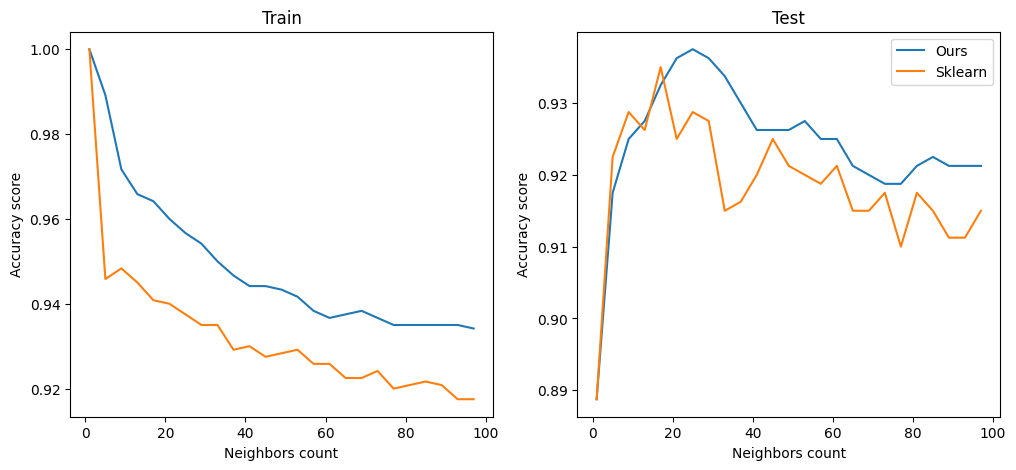

In [139]:
draw_graph(xn, our_trains, sklearn_trains, our_test, sklearn_test, label="aaaa")

In [ ]:
our_trains